In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
a1 = -2
b1 = 0.2
t1 = -1
w1 = 2
c1 = -1
d1 = 11
W1 = -4
W2 = -2

In [ ]:
def x1(t):
    indicator = (c1 <= t) & (t <= d1)
    return (a1 + b1 * np.abs(t - t1)) * np.cos(2 * np.pi * w1 * t) * indicator

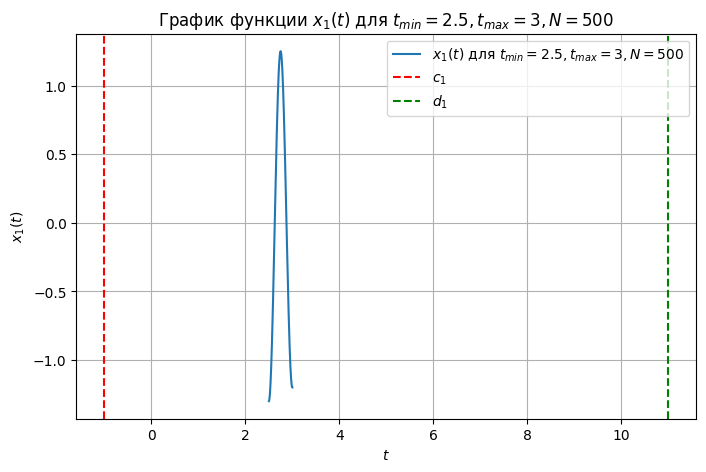

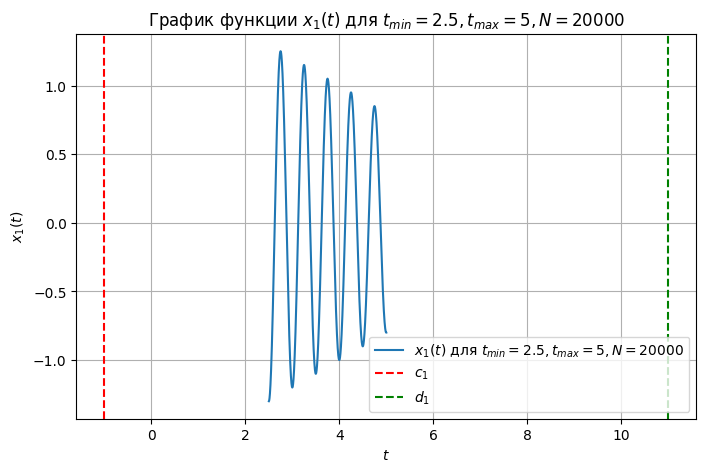

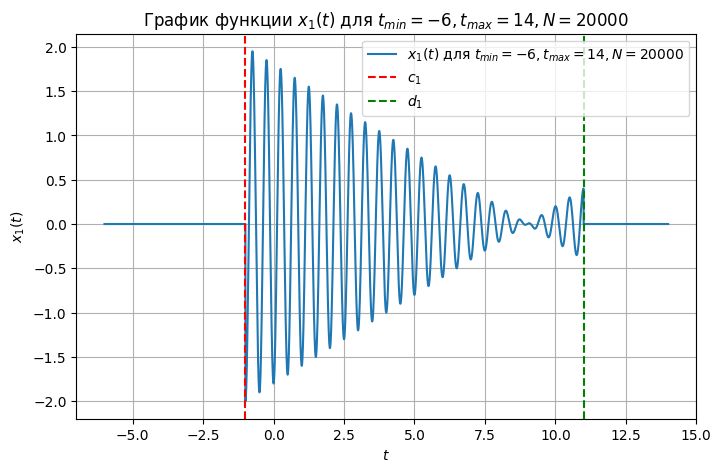

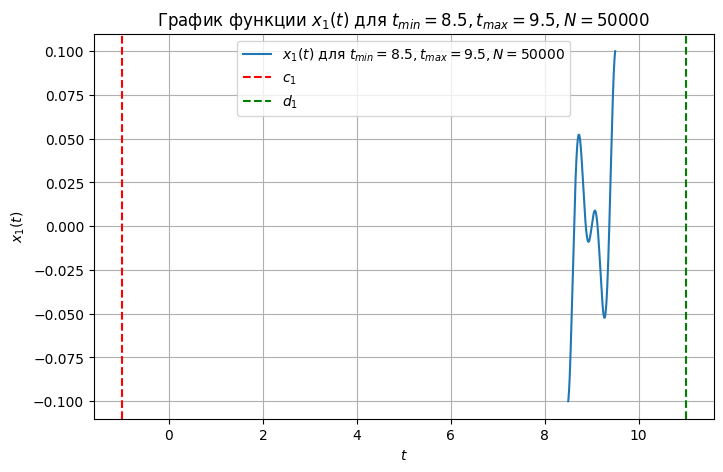

In [ ]:
ranges = [(2.5, 3, 500), (2.5, 5, 20000), (-6, 14, 20000), (8.5, 9.5, 50000)]

for i, (t_min, t_max, N) in enumerate(ranges):
    t = np.linspace(t_min, t_max, N)
    x_values = x1(t)

    plt.figure(figsize=(8, 5))
    plt.plot(t, x_values, label=f'$x_1(t)$ для $t_{{min}}={t_min}, t_{{max}}={t_max}, N={N}$')
    plt.axvline(c1, color='r', linestyle='--', label='$c_1$')
    plt.axvline(d1, color='g', linestyle='--', label='$d_1$')
    plt.xlabel('$t$')
    plt.ylabel('$x_1(t)$')
    plt.title(f'График функции $x_1(t)$ для $t_{{min}}={t_min}, t_{{max}}={t_max}, N={N}$')
    plt.legend()
    plt.grid()
    plt.show()

Свойства сигнала x1(t):  

*   Так как есть индикатор в заданной функции, то сигнал существует только на определенном отрезке и представляет собой некие колебания.
*   В некоторых вариантах сигнала видна огибающая, что указывает на наличие модуляции частоты или амплитуды.
*   При больших N хорошо видны детали сигнала, также их можно рассмотреть, сдвигая отрезок [t_min, t_max].


In [ ]:
import time

In [ ]:
def dft(t, x_t, freqs):
    N = len(t)
    M = len(freqs)
    dt = t[1] - t[0]
    Xf = np.zeros(M, dtype=complex)
    for k in range(M):
        e = np.exp(-2j * np.pi * freqs[k] * t)
        Xf[k] = np.sum(x_t * e) * dt
    return Xf

In [ ]:
def fft(x_t, dt):
    N = len(x_t)
    Xf = np.fft.fft(x_t) * dt
    freqs = np.fft.fftfreq(N, d=dt)
    return freqs, Xf

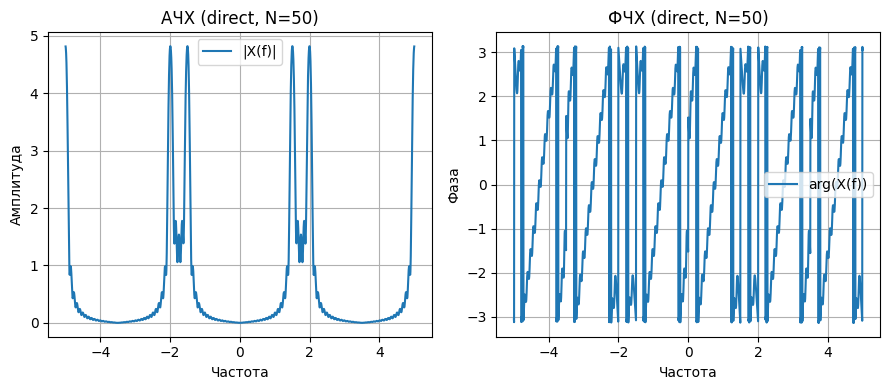

Метод: DIRECT, N=50, время вычисления: 0.02773 c, оценка flops=100000.00


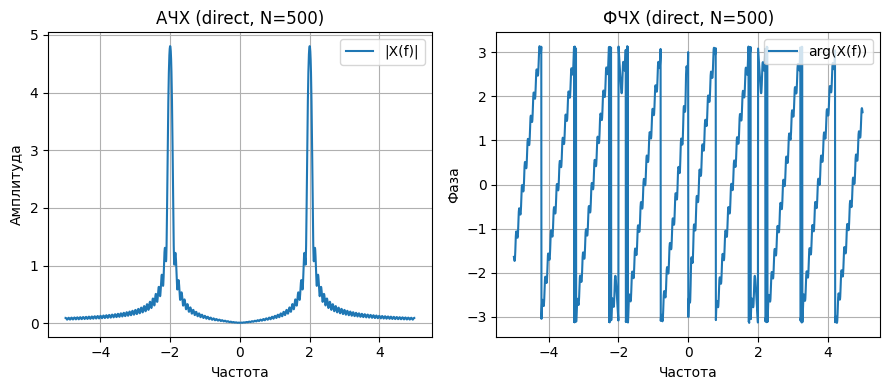

Метод: DIRECT, N=500, время вычисления: 0.13122 c, оценка flops=1000000.00


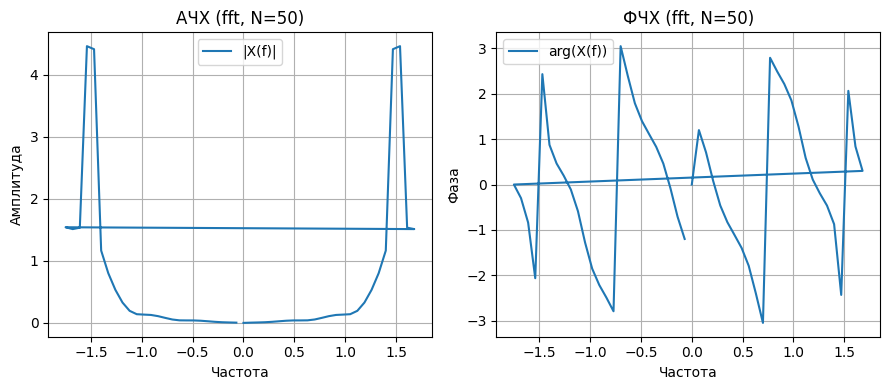

Метод: FFT, N=50, время вычисления: 0.00074 c, оценка flops=282.19


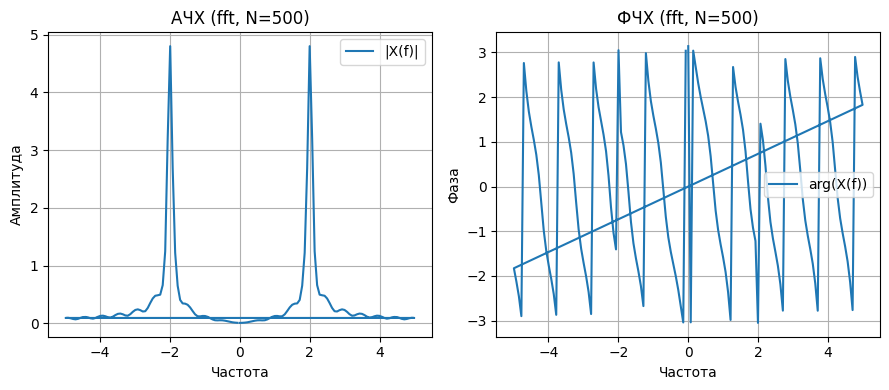

Метод: FFT, N=500, время вычисления: 0.00012 c, оценка flops=4482.89


In [ ]:
def spectral_analysis(t_min, t_max, N, M, delta_min, delta_max, method='direct'):
    t = np.linspace(t_min, t_max, N)
    x_t = x1(t)
    dt = t[1] - t[0]

    if method == 'direct':
        freqs = np.linspace(delta_min, delta_max, M)
        start_time = time.time()
        Xf = dft(t, x_t, freqs)
        elapsed = time.time() - start_time
        # Оценка числа операций
        flops_est = M * N
    elif method == 'fft':
        start_time = time.time()
        freqs_full, Xf_full = fft(x_t, dt)
        elapsed = time.time() - start_time
        flops_est = N * np.log2(N)
        mask = (freqs_full >= delta_min) & (freqs_full <= delta_max)
        freqs = freqs_full[mask]
        Xf = Xf_full[mask]

    plt.figure(figsize=(9, 4))
    plt.subplot(1,2,1)
    plt.plot(freqs, np.abs(Xf), label='|X(f)|')
    plt.xlabel('Частота'); plt.ylabel('Амплитуда')
    plt.title(f'АЧХ ({method}, N={N})')
    plt.grid(); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(freqs, np.angle(Xf), label='arg(X(f))')
    plt.xlabel('Частота'); plt.ylabel('Фаза')
    plt.title(f'ФЧХ ({method}, N={N})')
    plt.grid(); plt.legend()
    plt.tight_layout()
    plt.show()

    print(f'Метод: {method.upper()}, N={N}, время вычисления: {elapsed:.5f} c, оценка flops={flops_est:.2f}')

t_min, t_max = -2, 12
M = 2000
delta_min, delta_max = -5, 5

#ДПФ
spectral_analysis(t_min, t_max, N=50,  M=M, delta_min=delta_min, delta_max=delta_max, method='direct')
spectral_analysis(t_min, t_max, N=500, M=M, delta_min=delta_min, delta_max=delta_max, method='direct')

#БПФ
spectral_analysis(t_min, t_max, N=50,  M=M, delta_min=delta_min, delta_max=delta_max, method='fft')
spectral_analysis(t_min, t_max, N=500, M=M, delta_min=delta_min, delta_max=delta_max, method='fft')

*   Cпектр с максимумами вблизи частоты w₁ = 2 и ее гармоник.
*   при N = 500 хорошо видны детали сигнала
*   ДПФ обеспечивает высокое разрешение по частоте, но требует значительных вычислительных ресурсов при больших N.




In [ ]:
def ideals_filter(freqs, W1, W2):
  H = np.zeros_like(freqs, dtype=float)
  H[(freqs >= W1) & (freqs <= W2)] = 1.0
  H[(freqs >= -W2) & (freqs <= -W1)] = 1.0
  return H

In [ ]:
def IFT(freqs, Xf, t):
    M = len(freqs)
    y_t = np.zeros(len(t), dtype=complex)
    #y_t = np.zeros_like(t, dtype=complex)
    df = freqs[1] - freqs[0]
    print(f"Шаг частоты df = {df}")
    for n in range(len(t)):
        e = np.exp(2j * np.pi * freqs * t[n])
        y_t[n] = np.sum(Xf * e) * df

    return y_t


In [ ]:
def example_filtering_direct(t_min, t_max, N, W1, W2, M, f_min, f_max):
    t_time = np.linspace(t_min, t_max, N)
    x_signal = x1(t_time)
    f_freq = np.linspace(f_min, f_max, M)

    Xf = dft(t_time, x_signal, f_freq)

    H = ideals_filter(f_freq, W1, W2)

    Yf = Xf * H

    y_filtered = IFT(f_freq, Yf, t_time)

    # график фильтра
    plt.figure(figsize=(6, 3))
    plt.plot(f_freq, H, 'g-', label="H(f)")
    plt.xlabel('Частота, f')
    plt.ylabel('H(f)')
    plt.title('График идеального фильтра H(f)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # исходный, отфильтрованный сигналы
    plt.figure(figsize=(10, 4))
    plt.plot(t_time, x_signal, label='Исходный x(t)', color='orange')
    plt.plot(t_time, np.real(y_filtered), label='Отфильтрованный y(t)', linestyle='--', color='blue')
    plt.xlabel('Время, t')
    plt.ylabel('Амплитуда')
    plt.title(f'Фильтрация: N={N}, M={M}, фильтр [{W1}, {W2}]')
    plt.legend()
    plt.grid(True)
    plt.show()

    # спектральные характеристики
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(f_freq, np.abs(Yf), label='|Y(f)|', color='purple')
    plt.xlabel('Частота, f')
    plt.ylabel('Амплитуда')
    plt.title('АЧХ после фильтра')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(f_freq, np.angle(Yf), label='arg(Y(f))', color='brown')
    plt.xlabel('Частота, f')
    plt.ylabel('Фаза')
    plt.title('ФЧХ после фильтра')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Шаг частоты df = 0.02001000500250072


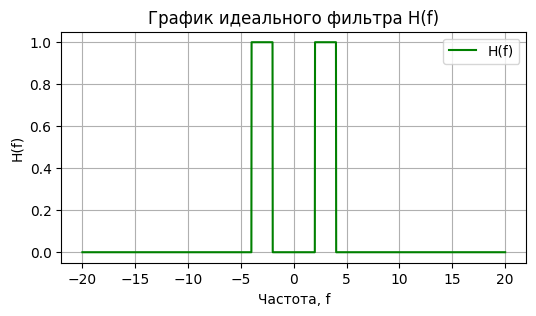

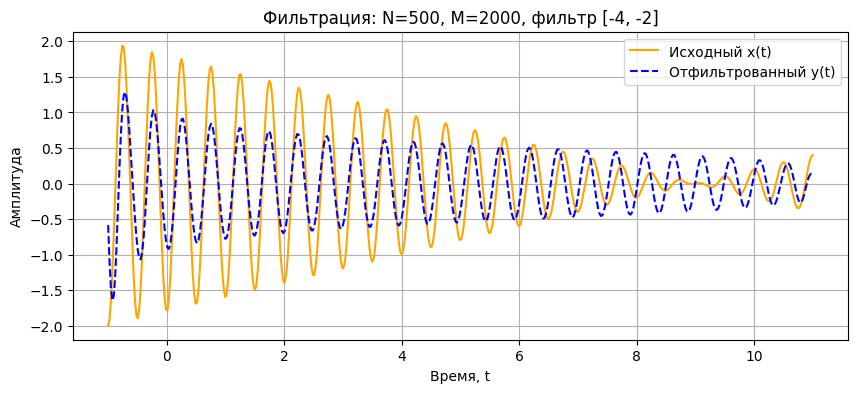

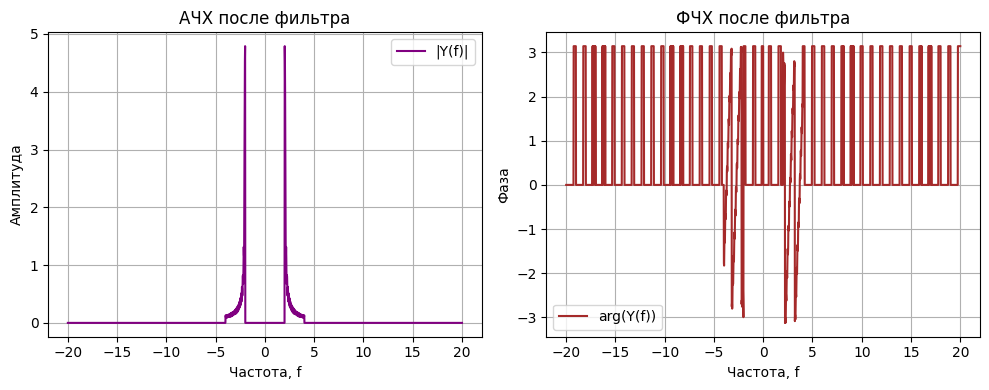

In [ ]:
example_filtering_direct(t_min=-1, t_max=11, N=500, W1=-4, W2=-2, M=2000, f_min=-20, f_max=20)


*   Видны колебания фильтра с убывающей огибающей
*   АЧХ после фильтрации: энергия сосредоточена строго в полосах [-4, -2] и [2, 4]
*   Фаза в полосе пропускания соответствует исходному сигналу, вне её — случайна.



